### pcQTLs improve interpretability of eQTLs shared by multiple genes and identify causal variants with smaller credible sets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from scipy.stats import ttest_rel, ranksums

from tqdm.auto import tqdm 
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

### a) all multi-gene eQTLs are pcQTLs (number e genes colored by if tagged by pcqtl)

In [2]:
# takes ~ 1:45
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals = remove_cross_map(underlying_signals, config=config)

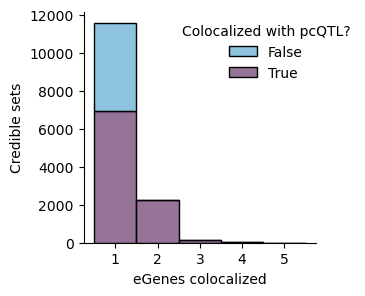

In [ ]:
underlying_signals['pcQTL'] = underlying_signals['num_pc_coloc']>0
underlying_signals['eQTL'] = underlying_signals['num_e_coloc']>0


fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(underlying_signals[(underlying_signals['num_e_coloc'] > 0)], x='num_e_coloc', hue='pcQTL', 
             multiple='stack', bins=range(1,7), palette={False:'#67AFD2', True:'#734675'},)

ax.set_xlabel('eGenes colocalized')
ax.set_ylabel('Credible sets')


# Change legend title
leg = ax.get_legend()
leg.set_title('Colocalized with pcQTL?')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_xticks([1.5,2.5,3.5,4.5, 5.5], [1,2,3,4, 5])
ax.set_yticks()

sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))

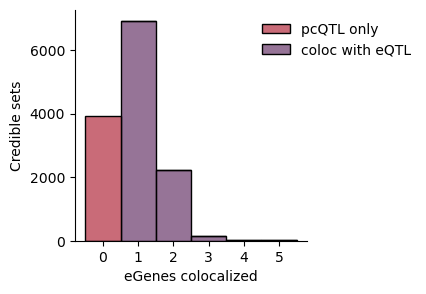

In [103]:
fig, ax = plt.subplots(figsize=(3,3))

sns.histplot(underlying_signals[underlying_signals['pcQTL']], x='num_e_coloc', hue='eQTL', 
             multiple='stack', discrete=True, palette={False:'#B83A4B', True:'#734675'},ax=ax)

ax.set_xlabel('eGenes colocalized')
ax.set_ylabel('Credible sets')
# ax.bar_label(ax.containers[0], fmt='%.0f', padding=.5)
# ax.bar_label(ax.containers[1], fmt='%.0f', padding=.5)

# Change legend title


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_yticks([0, 2000, 4000, 6000])
ax.set_xticks([0,1,2,3,4, 5])

leg = ax.get_legend()
sns.move_legend(ax, "upper right", labels=['pcQTL only', 'coloc with eQTL',], title='', bbox_to_anchor=(1.5, 1))

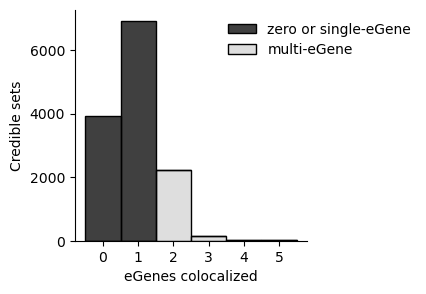

In [99]:
fig, ax = plt.subplots(figsize=(3,3))

sns.histplot(underlying_signals[underlying_signals['pcQTL']], x='num_e_coloc', hue='multiple_e', 
             multiple='stack', discrete=True, palette={False:'black', True:'lightgrey'},ax=ax)

ax.set_xlabel('eGenes colocalized')
ax.set_ylabel('Credible sets')
# ax.bar_label(ax.containers[0], fmt='%.0f', padding=.5)
# ax.bar_label(ax.containers[1], fmt='%.0f', padding=.5)

# Change legend title


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

ax.set_yticks([0, 2000, 4000, 6000])
ax.set_xticks([0,1,2,3,4, 5])

leg = ax.get_legend()
sns.move_legend(ax, "upper right", labels=['zero or single-eGene', 'multi-eGene',], title='', bbox_to_anchor=(1.5, 1))

### b) multi-gene vs single-gene eQTLs are enriched for regulatory regions


In [4]:
# enrichment 
susie_annotated = load_across_tissues(config, load_susie_annotated)

In [5]:
# break out by gene id so I can match vep effects to genes in the cluster
susie_annotated['gene_id'] = susie_annotated['cluster_id'].str.split('_')
susie_annotated_explode = susie_annotated.explode('gene_id')

def get_gene_matched_effect(row):
    gene_matched_effect = []
    for vep_effect in row['vep_info'].split(','):
        if row['gene_id'].split('.')[0] in vep_effect:
            gene_matched_effect.append(vep_effect.split('|')[1])
    return list(set(gene_matched_effect))

susie_annotated_explode['vep_info_gene'] = susie_annotated_explode.progress_apply(get_gene_matched_effect, axis=1).astype(str)

  0%|          | 0/2507495 [00:00<?, ?it/s]

In [6]:
# get a list of all the vep terms
small_susie = susie_annotated_explode.sample(100000)
small_susie['vep_info_gene_list'] = small_susie['vep_info_gene'].apply(ast.literal_eval)
small_susie = small_susie.explode('vep_info_gene_list')
small_susie['vep_info_gene_list_split'] = small_susie['vep_info_gene_list'].str.split('&')
small_susie.explode('vep_info_gene_list_split')['vep_info_gene_list_split'].value_counts()
# NMD_transcript_variant just means that the transcript undergoes NMD, not that the variant causes NMD

vep_info_gene_list_split
intron_variant                         26651
non_coding_transcript_variant           8348
downstream_gene_variant                 6686
upstream_gene_variant                   6355
NMD_transcript_variant                  5509
non_coding_transcript_exon_variant      1510
3_prime_UTR_variant                     1262
5_prime_UTR_variant                      487
missense_variant                         289
synonymous_variant                       286
splice_region_variant                    146
splice_polypyrimidine_tract_variant      123
splice_donor_region_variant               48
splice_donor_variant                      19
splice_donor_5th_base_variant             19
splice_acceptor_variant                   12
frameshift_variant                         8
stop_gained                                7
inframe_insertion                          5
inframe_deletion                           3
start_lost                                 2
stop_lost                     

In [7]:
# check for effects specific to a gene, with some groupings
#susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_gained|frameshift_variant', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_nmd'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_gained', regex=True).astype(float) * susie_annotated_explode['pip']

susie_annotated_explode['vep_gene_matched_exon'] = susie_annotated_explode['vep_info_gene'].str.contains('stop_retained_variant|missense_variant|synonymous_variant|exon_variant|stop_lost|protein_altering_variant|inframe_deletion|coding_sequence_variant|start_lost|inframe_insertion', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_intron'] = susie_annotated_explode['vep_info_gene'].str.contains('UTR_variant|intron_variant', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_splice'] = susie_annotated_explode['vep_info_gene'].str.contains('splice', regex=True).astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_gene_matched_neargene'] = susie_annotated_explode['vep_info_gene'].str.contains('downstream_gene_variant|upstream_gene_variant', regex=True).astype(float) * susie_annotated_explode['pip']

# any effect on the transcript
susie_annotated_explode['vep_any_effect'] = (susie_annotated_explode['vep_info_gene'].str.strip("'[],").apply(len) > 0).astype(float) * susie_annotated_explode['pip']

# vep related but not gene specific
susie_annotated_explode['vep_open_chrom'] = susie_annotated_explode['vep_info'].str.contains('open_chromatin_region').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_reg'] = susie_annotated_explode['vep_info'].str.contains('regulatory_region_variant').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_enhancer'] = susie_annotated_explode['vep_info'].str.contains('enhancer').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_promoter'] = susie_annotated_explode['vep_info'].str.contains('promoter').astype(float) * susie_annotated_explode['pip']
susie_annotated_explode['vep_CTCF'] = susie_annotated_explode['vep_info'].str.contains('CTCF_binding_site').astype(float) * susie_annotated_explode['pip']

In [8]:
# some annotaitons for the abc enhancers 
susie_annotated_explode['in_shared_abc'] = (susie_annotated_explode['qtl_matched_abc_genes'] > 1) * susie_annotated_explode['pip']
susie_annotated_explode['in_matched_abc'] = (susie_annotated_explode['qtl_matched_abc_genes'] > 0) * susie_annotated_explode['pip']
susie_annotated_explode['in_abc'] = (susie_annotated_explode['qtl_num_abc_enhancers'] > 0) * susie_annotated_explode['pip']
susie_annotated_explode['qtl_in_tad'] = (susie_annotated_explode['qtl_in_tad']) * susie_annotated_explode['pip']

In [9]:
# group by egene
egene_grouped = susie_annotated_explode.groupby(['phenotype_id', 'tissue_id', 'cs_id', 'gene_id', 'cluster_id']).agg({'vep_gene_matched_nmd':'sum', 
                                                                                                                        'vep_gene_matched_exon':'sum', 
                                                                                                                        'vep_gene_matched_intron':'sum',
                                                                                                                        'vep_gene_matched_splice':'sum',
                                                                                                                        'vep_any_effect':'sum',
                                                                                                                        'vep_open_chrom':'sum',
                                                                                                                        'vep_enhancer':'sum',
                                                                                                                        'vep_promoter':'sum',
                                                                                                                        'vep_CTCF':'sum',
                                                                                                                        'in_shared_abc':'sum',
                                                                                                                        'in_matched_abc':'sum',
                                                                                                                        'in_abc':'sum',
                                                                                                                        'qtl_in_tad':'sum',
                                                                                                                        'pip':'sum',
                                                                                                                        'type':'first'})

In [10]:
# group into credible sets over egenes. take the max and the count of those greater than 0 for each category
cs_grouped = egene_grouped.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'cluster_id']).agg(max_vep_nmd=('vep_gene_matched_nmd','max'),
                                                                                             count_vep_nmd=('vep_gene_matched_nmd',lambda x: (x > 0).sum()),
                                                                                             max_vep_exon=('vep_gene_matched_exon','max'),
                                                                                             count_vep_exon=('vep_gene_matched_exon',lambda x: (x > 0).sum()),
                                                                                             max_vep_intron=('vep_gene_matched_intron','max'),
                                                                                             count_vep_intron=('vep_gene_matched_intron',lambda x: (x > 0).sum()),
                                                                                             max_vep_splice=('vep_gene_matched_splice','max'),
                                                                                             count_vep_splice=('vep_gene_matched_splice',lambda x: (x > 0).sum()),
                                                                                             max_vep_any=('vep_any_effect','max'),
                                                                                             count_vep_any=('vep_any_effect',lambda x: (x > 0).sum()),
                                                                                             vep_open_chrom=('vep_open_chrom','max'),
                                                                                             vep_enhancer=('vep_enhancer','max'),
                                                                                             vep_promoter=('vep_promoter','max'),
                                                                                             vep_CTCF=('vep_CTCF','max'),
                                                                                             in_shared_abc=('in_shared_abc','max'),
                                                                                             in_matched_abc=('in_matched_abc','max'),
                                                                                             in_abc=('in_abc','max'),
                                                                                             qtl_in_tad=('qtl_in_tad','max'),
                                                                                             type=('type', 'first'))

In [66]:
# merge in signal group informaiton
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')
cs_grouped_signal_annotated = pd.merge(underlying_signals.explode('cs_id'), cs_grouped, on=['cs_id', 'tissue_id'], how='left')
cs_grouped_signal_annotated = cs_grouped_signal_annotated[~(cs_grouped_signal_annotated['max_vep_any'].isna())]

# group over signals and take the mean of each column
signal_grouped = cs_grouped_signal_annotated.groupby(['signal_id', 'tissue_id', 'cluster_id']).agg(dict([(col, 'mean') for col in cs_grouped.columns[:-1]]))
signal_grouped = pd.merge(underlying_signals, signal_grouped, on=['signal_id', 'tissue_id'], how='left')
signal_grouped['cluster_size'] = signal_grouped['cluster_id'].str.split('_').apply(len)
signal_grouped = signal_grouped[~signal_grouped['max_vep_nmd'].isna()]

In [67]:
cs_grouped_signal_annotated['vep_single_gene'] = (cs_grouped_signal_annotated['count_vep_any'] <= 1) & (cs_grouped_signal_annotated['max_vep_any']!=0)
cs_grouped_signal_annotated['vep_multi_gene'] = cs_grouped_signal_annotated['count_vep_any'] > 1
signal_grouped['vep_single_gene'] = (signal_grouped['count_vep_any'] <= 1) & (signal_grouped['max_vep_any']!=0)
signal_grouped['vep_multi_gene'] = signal_grouped['count_vep_any'] > 1
cs_grouped_signal_annotated['cluster_size'] = cs_grouped_signal_annotated['cluster_id'].str.split('_').apply(len)

In [70]:
final_plot_columns = ['vep_multi_gene', 'vep_single_gene', 'vep_CTCF', 'qtl_in_tad', 'vep_enhancer', 'vep_promoter', 'max_vep_splice', 'count_vep_nmd']
or_multigene = get_odds_df(cs_grouped_signal_annotated[(cs_grouped_signal_annotated['pcQTL'])], label_col='multiple_e', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size').reset_index()


count_vep_nmd
Optimization terminated successfully.
         Current function value: 0.596227
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                27488
Model:                          Logit   Df Residuals:                    27485
Method:                           MLE   Df Model:                            2
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                0.004262
Time:                        08:56:05   Log-Likelihood:                -16389.
converged:                       True   LL-Null:                       -16459.
Covariance Type:            nonrobust   LLR p-value:                 3.451e-31
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4081      0.047    -30.144      0.000      -1.500      -1.317
cluste

/local/scratch/klawren/slrmtmp.47796407/ipykernel_17973/440745949.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['VEP effect on multiple genes', 'VEP effect on only 1 gene', 'CTCF site', 'TAD boundary', 'enhancer', 'promoter', 'splice site', 'stop-gain'][::-1])


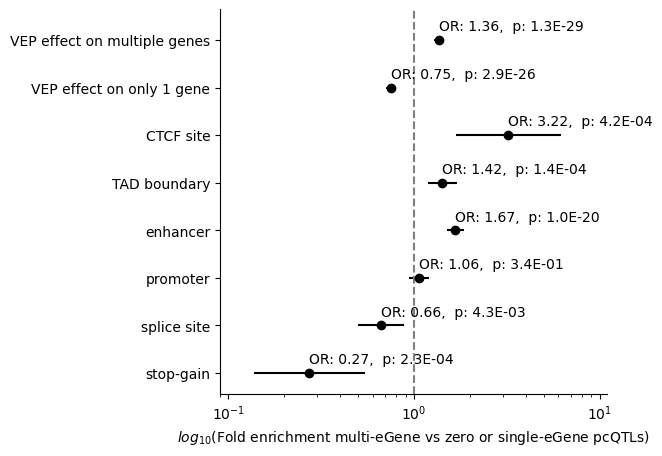

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y=or_multigene['col'], x=or_multigene['odds_ratio'], xerr=np.clip(or_multigene[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt="o", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_multigene.iterrows():
    ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=10)

# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
ax.set_yticklabels(['VEP effect on multiple genes', 'VEP effect on only 1 gene', 'CTCF site', 'TAD boundary', 'enhancer', 'promoter', 'splice site', 'stop-gain'][::-1])

# format the x axis
ax.set_xlabel(r'$log_{10}$(Fold enrichment multi-eGene vs zero or single-eGene pcQTLs)')
ax.set_xscale('log')
ax.set_xticks([.1, 1, 10])
ax.set_xlim([.09, 11])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

count_vep_nmd
Optimization terminated successfully.
         Current function value: 0.693031
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                55706
Model:                          Logit   Df Residuals:                    55703
Method:                           MLE   Df Model:                            2
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:               4.345e-05
Time:                        11:26:11   Log-Likelihood:                -38606.
converged:                       True   LL-Null:                       -38608.
Covariance Type:            nonrobust   LLR p-value:                    0.1868
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0782      0.032     -2.465      0.014      -0.140      -0.016
cluste

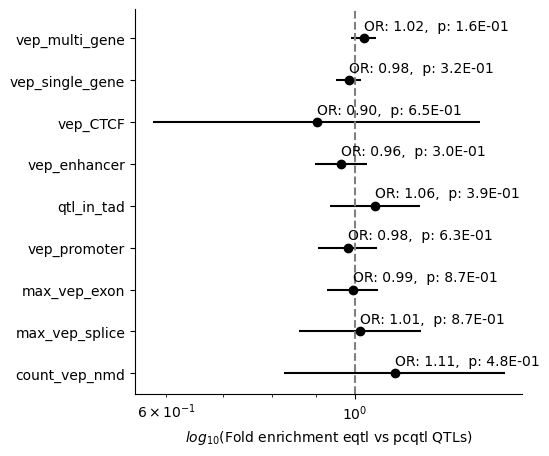

In [104]:
# plot for pc vs e qtl
final_plot_columns = ['vep_multi_gene', 'vep_single_gene', 'vep_CTCF', 'vep_enhancer', 'qtl_in_tad', 'vep_promoter', 'max_vep_exon', 'max_vep_splice', 'count_vep_nmd']
or_multigene = get_odds_df(pd.concat([cs_grouped_signal_annotated[cs_grouped_signal_annotated['num_e_coloc']>0], cs_grouped_signal_annotated[cs_grouped_signal_annotated['num_pc_coloc']>0]],  keys=[False, True], names=['is_pcqtl', 'idx'])
                           , label_col='is_pcqtl', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='cluster_size').reset_index()


fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y=or_multigene['col'], x=or_multigene['odds_ratio'], xerr=np.clip(or_multigene[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt="o", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_multigene.iterrows():
    ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=10)

# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
#ax.set_yticklabels(['VEP effect on only 1 gene', 'VEP effect on all genes', 'Splicing', 'NMD', 'Promoter', 'Shared promoter', 'Enhancer', 'TAD boundry', 'CTCF site'][::-1])

# format the x axis
ax.set_xlabel(r'$log_{10}$(Fold enrichment eqtl vs pcqtl QTLs)')
ax.set_xscale('log')
#ax.set_xticks([.5, 1, 10])
#ax.set_xlim([.5, 11])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

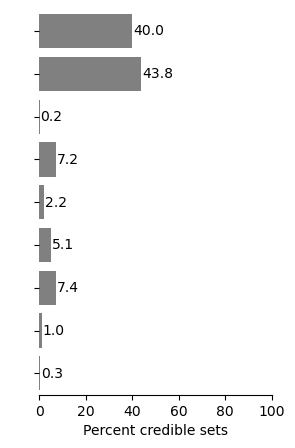

In [16]:
# fraction of multigene in each category (any varaint in credible set is in category)
multigene_categories = cs_grouped_signal_annotated[final_plot_columns]>.5

fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(multigene_categories.mean(axis=0)*100, orient='h', color='grey')
ax.bar_label(ax.containers[0], fmt='%.1f', padding=.5)
ax.set_ylabel(" ")
ax.set_xlabel("Percent credible sets")
ax.set_xlim([0,100])
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

### c) smaller credible sets sizes for pcQTLs

In [17]:
multigene_signals = underlying_signals[underlying_signals['num_e_coloc']>1]

In [18]:
# Create a mapping of cs_id and tissue_id to their corresponding counts
count_map = susie_annotated.groupby(['cs_id', 'tissue_id']).size().reset_index(name='count')

def get_cs_sizes(row):
    pc_cs_sizes = []
    e_cs_sizes = []
    # Iterate over each cs_id present in the row
    for cs_id in row['cs_id']:
        # Match corresponding counts from count_map
        match = count_map[(count_map['cs_id'] == cs_id) & (count_map['tissue_id'] == row['tissue_id'])]
        if not match.empty:
            cs_size = match['count'].values[0]
            if '_pc' in cs_id:
                pc_cs_sizes.append(cs_size)
            else:
                e_cs_sizes.append(cs_size)
    # Calculate median and min sizes
    if pc_cs_sizes:
        row['median_pc_cs_size'] = np.median(pc_cs_sizes)
        row['min_pc_cs_size'] = np.min(pc_cs_sizes)
    else:
        row['median_pc_cs_size'] = np.nan
        row['min_pc_cs_size'] = np.nan
    if e_cs_sizes:
        row['median_e_cs_size'] = np.median(e_cs_sizes)
        row['min_e_cs_size'] = np.min(e_cs_sizes)
    else:
        row['median_e_cs_size'] = np.nan
        row['min_e_cs_size'] = np.nan
    return row

multigene_signals = multigene_signals.progress_apply(get_cs_sizes, axis=1)
# remove nas
multigene_signals = multigene_signals[~(multigene_signals['median_e_cs_size'].isna())&~(multigene_signals['median_pc_cs_size'].isna())]

  0%|          | 0/2432 [00:00<?, ?it/s]

TtestResult(statistic=11.299044715160438, pvalue=7.083399416202484e-29, df=2386)
RanksumsResult(statistic=6.4720501587245804, pvalue=9.668201374385273e-11)


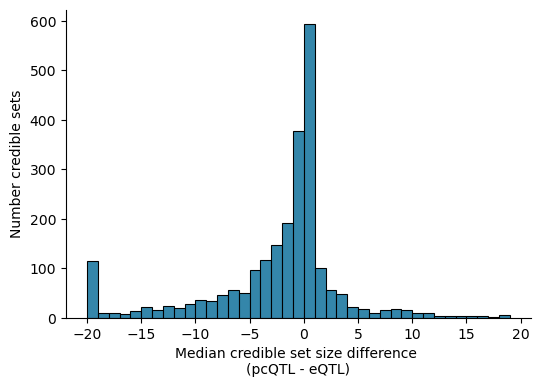

In [19]:
# just multigene signals
clip=20

multigene_signals['size_diff'] = multigene_signals['median_pc_cs_size'] - multigene_signals['median_e_cs_size']
multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-clip, clip)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(multigene_signals, x='size_diff', bins = np.arange(-clip, clip, 1), ax=ax, alpha=.8,
             color='#016895')
             #hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'})
ax.set_xlabel('Median credible set size difference \n(pcQTL - eQTL)')
ax.set_ylabel('Number credible sets')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(ttest_rel(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))
print(ranksums(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))

### shared variant effect sizes and directions

In [20]:
susie_annotated = load_across_tissues(config, load_susie_annotated)
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].progress_apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].progress_apply(ast.literal_eval)

  0%|          | 0/892013 [00:00<?, ?it/s]

  0%|          | 0/892013 [00:00<?, ?it/s]

In [21]:
# expand out over all egenes for a given qtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])

# weight by pip
susie_annotated_egene_explode['pip_weighted_eqtl_slope'] = susie_annotated_egene_explode['egene_qtl_slope']*susie_annotated_egene_explode['pip']

# group by egene
egene_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_eqtl_slope':sum}).reset_index()

# group by credible set
cs_grouped_eqtl_mapped = egene_grouped_eqtl_mapped.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pip_weighted_eqtl_slope':list}).reset_index()


# look just at pairs at first
cs_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped[cs_grouped_eqtl_mapped['cluster_id'].str.split('_').apply(len) < 3]

# add the two slopes
cs_grouped_eqtl_mapped_pairs['slope_gene_a'] = cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[0]
cs_grouped_eqtl_mapped_pairs['slope_gene_b'] = cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[1]

/local/scratch/klawren/slrmtmp.47796407/ipykernel_17973/1155871281.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_grouped_eqtl_mapped_pairs['slope_gene_a'] = cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[0]
/local/scratch/klawren/slrmtmp.47796407/ipykernel_17973/1155871281.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs_grouped_eqtl_mapped_pairs['slope_gene_b'] = cs_grouped_eqtl_mapped_pairs['pip_weighted_eqtl_slope'].str[1]


In [118]:
cs_grouped_eqtl_mapped_pairs_annotated

,phenotype_id,cs_id,tissue_id,type,cluster_id,lead_variant_id,egene_id_list,pip_weighted_eqtl_slope,slope_gene_a,slope_gene_b,signal_id,num_e_coloc,num_pc_coloc,multiple_e,multiple_pc,cluster_id_signal,lead_var_set,var_set,pcQTL,lead_var_position
0,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,Artery_Tibial,eqtl,ENSG00000000971.15_ENSG00000162687.16,chr1_196544193_A_G_b38,"[ENSG00000000971.15, ENSG00000162687.16]","[-0.01912395399454256, -0.024089615976427167]",-0.019124,-0.024090,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,2,1,True,False,ENSG00000000971.15_ENSG00000162687.16,"[chr1_196430102_G_A_b38, chr1_196544193_A_G_b38]","[chr1_196599564_C_T_b38, chr1_196380022_C_T_b3...",True,196544193
1,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,Cells_Cultured_fibroblasts,eqtl,ENSG00000000971.15_ENSG00000162687.16,chr1_196657827_GAAT_G_b38,"[ENSG00000000971.15, ENSG00000162687.16]","[-0.06688112352772435, -0.00282137037057588]",-0.066881,-0.002821,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,1,1,False,False,ENSG00000000971.15_ENSG00000162687.16,"[chr1_196657827_GAAT_G_b38, chr1_196654830_G_A...","[chr1_196648590_G_A_b38, chr1_196641721_T_C_b3...",True,196657827
2,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,Esophagus_Muscularis,eqtl,ENSG00000000971.15_ENSG00000162687.16,chr1_196429489_T_C_b38,"[ENSG00000000971.15, ENSG00000162687.16]","[-0.024163892685784887, -0.02841049323762228]",-0.024164,-0.028410,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,2,1,True,False,ENSG00000000971.15_ENSG00000162687.16,"[chr1_196429489_T_C_b38, chr1_196419837_T_C_b38]","[chr1_196421983_C_G_b38, chr1_196431864_A_G_b3...",True,196429489
3,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,Lung,eqtl,ENSG00000000971.15_ENSG00000162687.16,chr1_196426741_G_A_b38,"[ENSG00000000971.15, ENSG00000162687.16]","[-0.010440770914726817, -0.0041321309094860086]",-0.010441,-0.004132,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,1,0,False,False,ENSG00000000971.15_ENSG00000162687.16,[chr1_196426741_G_A_b38],"[chr1_196418502_G_A_b38, chr1_196380022_C_T_b3...",False,196426741
4,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,Nerve_Tibial,eqtl,ENSG00000000971.15_ENSG00000162687.16,chr1_196545046_A_T_b38,"[ENSG00000000971.15, ENSG00000162687.16]","[-0.032301010738859555, -0.02378809839752935]",-0.032301,-0.023788,ENSG00000000971.15_ENSG00000162687.16_e_ENSG00...,1,0,False,False,ENSG00000000971.15_ENSG00000162687.16,[chr1_196545046_A_T_b38],"[chr1_196525417_T_C_b38, chr1_196545046_A_T_b38]",False,196545046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27742,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,Whole_Blood,eqtl,ENSG00000278259.4_ENSG00000278311.4,chr17_36544987_C_G_b38,"[ENSG00000278259.4, ENSG00000278311.4]","[-0.018303605144855076, 0.022816304398858803]",-0.018304,0.022816,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,2,1,True,False,ENSG00000278259.4_ENSG00000278311.4,"[chr17_36513312_A_G_b38, chr17_36544987_C_G_b38]","[chr17_36541028_A_G_b38, chr17_36573163_G_A_b3...",True,36544987
27743,ENSG00000278259.4_ENSG00000278311.4_pc1,ENSG00000278259.4_ENSG00000278311.4_pc1_cs_1,Adipose_Subcutaneous,pcqtl,ENSG00000278259.4_ENSG00000278311.4,chr17_36485825_C_A_b38,"[ENSG00000278259.4, ENSG00000278311.4]","[-0.02823151670761868, 0.03057179205654365]",-0.028232,0.030572,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,1,1,False,False,ENSG00000278259.4_ENSG00000278311.4,[chr17_36485825_C_A_b38],"[chr17_36542873_G_T_b38, chr17_36521034_T_A_b3...",True,36485825
27744,ENSG00000278259.4_ENSG00000278311.4_pc1,ENSG00000278259.4_ENSG00000278311.4_pc1_cs_1,Esophagus_Mucosa,pcqtl,ENSG00000278259.4_ENSG00000278311.

In [121]:
# group over underlying signals 
cs_grouped_eqtl_mapped_pairs_annotated = pd.merge(cs_grouped_eqtl_mapped_pairs, underlying_signals.explode('cs_id'), on=['tissue_id','cs_id'], how='inner', suffixes=['', '_signal'])
cs_grouped_eqtl_mapped_pairs_annotated['lead_var_position'] = cs_grouped_eqtl_mapped_pairs_annotated['lead_variant_id'].str.split('_').str[1].astype(int)

# egene id lists are in the same order for all signals
signal_grouped_eqtl_mapped_pairs = cs_grouped_eqtl_mapped_pairs_annotated.groupby(['signal_id', 'tissue_id']).agg({'slope_gene_a':'mean',
                                                                                                                   'slope_gene_b':'mean',
                                                                                                                   'egene_id_list':'first',
                                                                                                                   'num_e_coloc':'first',
                                                                                                                   'num_pc_coloc':'first',
                                                                                                                   'cluster_id':'first',
                                                                                                                   'lead_var_position':'mean'}).reset_index()

# annotate with cluster info
clusters = load_across_tissues(config, load_clusters_annotated)
signal_grouped_eqtl_mapped_pairs = pd.merge(signal_grouped_eqtl_mapped_pairs, clusters, on=['tissue_id', 'cluster_id'])

In [123]:
# annotate the distance between the genes and the variant
gid_gencode, full_gencode = load_gencode()

def get_var_distances(row):
    return (gid_gencode.loc[row['egene_id_list']]['tss_start'] - row['lead_var_position']).values
signal_grouped_eqtl_mapped_pairs[['dist_gene_a', 'dist_gene_b']] = signal_grouped_eqtl_mapped_pairs.progress_apply(get_var_distances, axis=1).apply(pd.Series)

# map the slopes to closer and further
signal_grouped_eqtl_mapped_pairs['slope_gene_closer'] = np.where(signal_grouped_eqtl_mapped_pairs['dist_gene_a']<signal_grouped_eqtl_mapped_pairs['dist_gene_b'], signal_grouped_eqtl_mapped_pairs['slope_gene_a'], signal_grouped_eqtl_mapped_pairs['slope_gene_b'])
signal_grouped_eqtl_mapped_pairs['slope_gene_further'] = np.where(signal_grouped_eqtl_mapped_pairs['dist_gene_a']<signal_grouped_eqtl_mapped_pairs['dist_gene_b'], signal_grouped_eqtl_mapped_pairs['slope_gene_b'], signal_grouped_eqtl_mapped_pairs['slope_gene_a'])

  0%|          | 0/15429 [00:00<?, ?it/s]

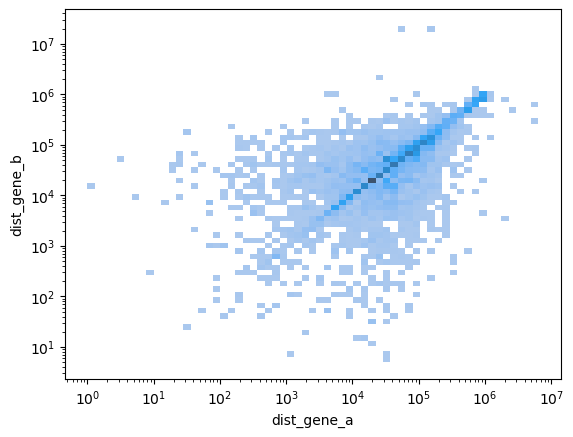

In [124]:
ax = sns.histplot(signal_grouped_eqtl_mapped_pairs, x='dist_gene_a', y='dist_gene_b', log_scale=True)

In [125]:
# make the closer egene beta positive
signal_grouped_eqtl_mapped_pairs['slope_gene_closer_flipped'] = np.abs(signal_grouped_eqtl_mapped_pairs['slope_gene_closer'])
signal_grouped_eqtl_mapped_pairs['slope_gene_further_flipped'] = np.where(signal_grouped_eqtl_mapped_pairs['slope_gene_closer'] > 0, 
                                                                          signal_grouped_eqtl_mapped_pairs['slope_gene_further'],
                                                                          - signal_grouped_eqtl_mapped_pairs['slope_gene_further'])


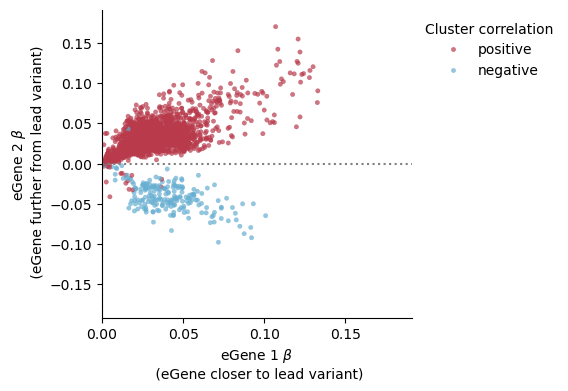

In [160]:
fig, ax = plt.subplots(figsize=(4,4))

multigene_signal_grouped = signal_grouped_eqtl_mapped_pairs[signal_grouped_eqtl_mapped_pairs['num_e_coloc']>1]

sns.scatterplot(multigene_signal_grouped, x='slope_gene_closer_flipped', y='slope_gene_further_flipped', edgecolor=None, s=10, alpha=.7,
                hue='has_neg_corr',  palette={True:'#67AFD2', False:'#B83A4B'})
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel(r'eGene 2 $\beta$' + '\n (eGene further from lead variant)')
ax.set_xlabel(r'eGene 1 $\beta$' + '\n (eGene closer to lead variant)')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='Cluster correlation', labels=['positive', 'negative'])

max_beta = max(signal_grouped_eqtl_mapped_pairs['slope_gene_closer'].max(), signal_grouped_eqtl_mapped_pairs['slope_gene_further'].max())
ax.set_xlim(0, max_beta)
ax.set_ylim(-max_beta, max_beta)

ax.axhline(0, ls=':', color='grey')
ax.axvline(0, ls=':', color='grey')

<AxesSubplot: xlabel='vep_open_chrom', ylabel='Count'>

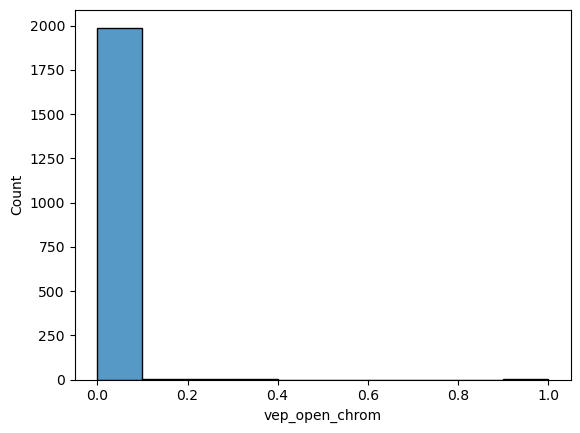

In [185]:
sns.histplot(multigene_signal_grouped_annotated['vep_open_chrom'], bins=10)

In [172]:
multigene_signal_grouped_annotated.columns.values

array(['signal_id', 'num_e_coloc', 'num_pc_coloc', 'multiple_e',
       'multiple_pc', 'cluster_id', 'lead_var_set', 'var_set',
       'tissue_id', 'pcQTL', 'cs_id', 'eQTL', 'max_vep_nmd',
       'count_vep_nmd', 'max_vep_exon', 'count_vep_exon',
       'max_vep_intron', 'count_vep_intron', 'max_vep_splice',
       'count_vep_splice', 'max_vep_any', 'count_vep_any',
       'vep_open_chrom', 'vep_enhancer', 'vep_promoter', 'vep_CTCF',
       'in_shared_abc', 'in_matched_abc', 'in_abc', 'qtl_in_tad', 'type',
       'vep_single_gene', 'vep_multi_gene', 'cluster_size',
       'tissue_idmerged', 'slope_gene_a', 'slope_gene_b', 'egene_id_list',
       'num_e_colocmerged', 'num_pc_colocmerged', 'cluster_idmerged',
       'lead_var_position', 'N_genes', 'Transcripts', 'Perc_cor',
       'Mean_cor', 'Mean_pos_cor', 'Mean_neg_cor', 'Chromosome', 'Tissue',
       'cluster_sizemerged', 'cluster_tss_size', 'start', 'end',
       'tss_min', 'tss_max', 'tss_inter', 'gene_inter', 'num_tads_gene',
    

In [168]:
multigene_signal_grouped_annotated = pd.merge(cs_grouped_signal_annotated[cs_grouped_signal_annotated['pcQTL']].drop_duplicates('signal_id'), multigene_signal_grouped, on='signal_id', how='inner', suffixes=['', 'merged'])
multigene_signal_grouped_annotated['concordent']  = multigene_signal_grouped_annotated['slope_gene_further_flipped'] > 0

In [209]:
multigene_signal_grouped_annotated['in_bi_promoter'] = multigene_signal_grouped_annotated['has_bidirectional_promoter'] * multigene_signal_grouped_annotated['vep_promoter']
multigene_signal_grouped_annotated['in_non_bi_promoter'] = (1-multigene_signal_grouped_annotated['has_bidirectional_promoter']) * multigene_signal_grouped_annotated['vep_promoter']

In [259]:
# concordent vs discordent
final_plot_columns = ['vep_CTCF', 'in_bi_promoter', 'vep_enhancer', 'vep_promoter', 'qtl_in_tad', 'has_neg_corr']
or_concordent = get_odds_df(multigene_signal_grouped_annotated, label_col='concordent', column_list=final_plot_columns[::-1], correct_on=True, correct_on_column='slope_gene_closer_flipped').reset_index()

has_neg_corr
Optimization terminated successfully.
         Current function value: 0.049797
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1996
Model:                          Logit   Df Residuals:                     1993
Method:                           MLE   Df Model:                            2
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.8538
Time:                        11:56:28   Log-Likelihood:                -99.394
converged:                       True   LL-Null:                       -679.94
Covariance Type:            nonrobust   LLR p-value:                7.448e-253
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.0617      0.422      7.257      

/local/scratch/klawren/slrmtmp.47796407/ipykernel_17973/1839400758.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['CTCF', 'Bidirectional promoter', 'Enhancer', 'All promoters', 'TAD boundry', 'Negative correlation'][::-1])


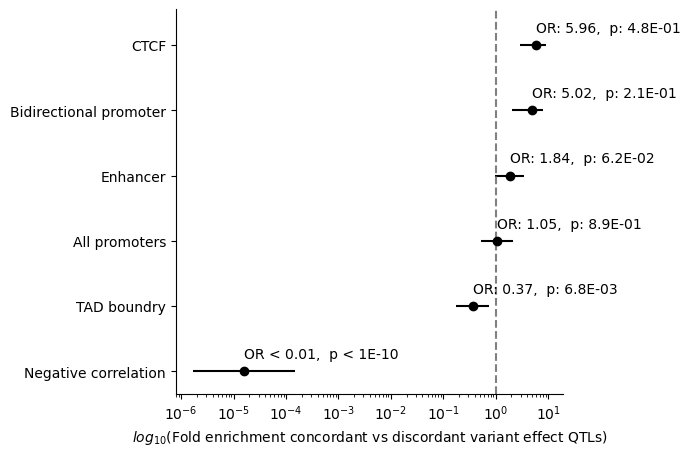

In [262]:
# plot for concordent vs discordent
fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(y=or_concordent['col'], x=or_concordent['odds_ratio'], xerr=np.clip(or_concordent[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), -3, 3), fmt="o", color='k')
# add line at 0
ax.axvline(1, color='grey', linestyle='--')
# add annotations
for idx, row in or_concordent.iterrows():
    if row['odds_ratio'] > .001:
        ax.annotate('OR: {:.2f},  p: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=10)
    else:
        ax.annotate('OR < 0.01,  p < 1E-10'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2), fontsize=10)


# give some more space on the y axis
ax.set_ylim((ax.get_ylim()[0]-.1, ax.get_ylim()[1]+.3))
ax.set_yticklabels(['CTCF', 'Bidirectional promoter', 'Enhancer', 'All promoters', 'TAD boundry', 'Negative correlation'][::-1])

# format the x axis
ax.set_xlabel(r'$log_{10}$(Fold enrichment concordant vs discordant variant effect QTLs)')
ax.set_xscale('log')
#ax.set_xticks([.5, 1, 10])
#ax.set_xlim([.5, 11])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)